In [43]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imwrite
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [44]:
import os
from glob import glob

# CHANGE PATH

pth = r'C:\Users\Donald\Desktop\AD_IF_Images\AD brain tissue images_ImmunoFluorescence\20231115_Shared\5xFAD 12MO F3-1_IF slide1'  # path of tif files
WSIs = sorted(glob(f'{pth}\*.tif'))

In [45]:
WSIs

['C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\5xFAD 12MO F3-1_C=0_DAPI_Nucleus.tif',
 'C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\5xFAD 12MO F3-1_C=1_EGFP_ThioflavinS.tif',
 'C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\5xFAD 12MO F3-1_C=2_AF568_Iba1.tif',
 'C:\\Users\\Donald\\Desktop\\AD_IF_Images\\AD brain tissue images_ImmunoFluorescence\\20231115_Shared\\5xFAD 12MO F3-1_IF slide1\\5xFAD 12MO F3-1_C=3_Cy5_S100b.tif']

In [46]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [47]:
from csbdeep.utils import normalize
import sys
from tqdm import tqdm

ind = 0  # which image in directory list you are loading

# you might need to run "pip install imagecodecs" if you get jpeg compression error

img = imread(WSIs[ind])
n_channel = 1 if img[0].ndim == 2 else img[0].shape[-1]  #If no third

img = img/65535

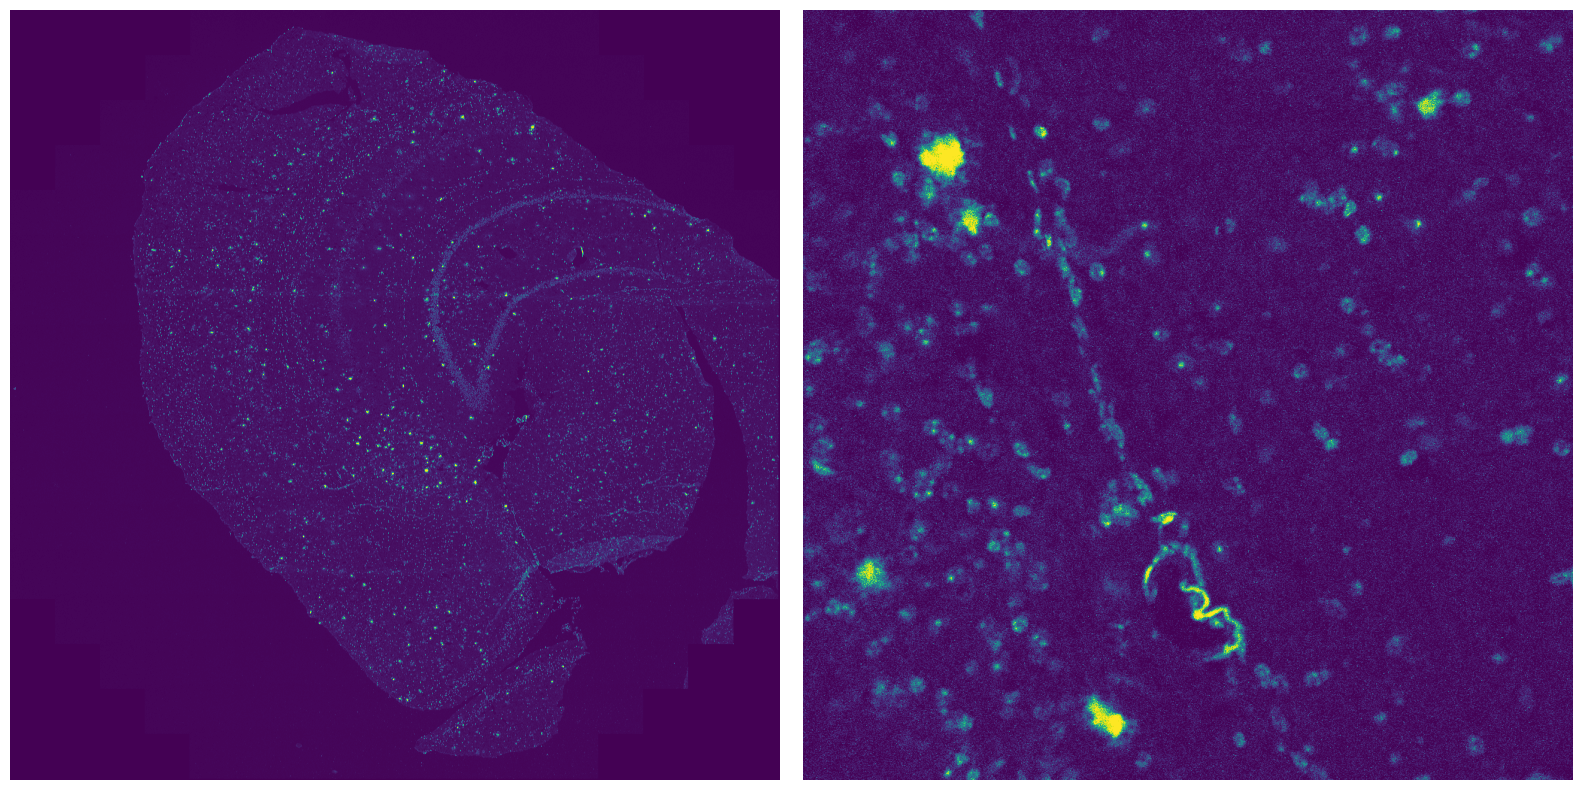

In [48]:
show_image(img, crop_x=10000, crop_y=10000, tile_size=1024)

In [49]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [50]:
model

StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1, 1), train_epochs=800, train_steps_per_epoch=400, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=None, train_tensorboard=True, tr

In [51]:
img = imread(WSIs[2])

img = img / 65535

labels, polys = model.predict_instances_big(img, axes='YX', block_size=4096, min_overlap=128, context=128, n_tiles=(4,4))

effective: block_size=(4096, 4096), min_overlap=(128, 128), context=(128, 128)


100%|██████████| 25/25 [01:00<00:00,  2.41s/it]


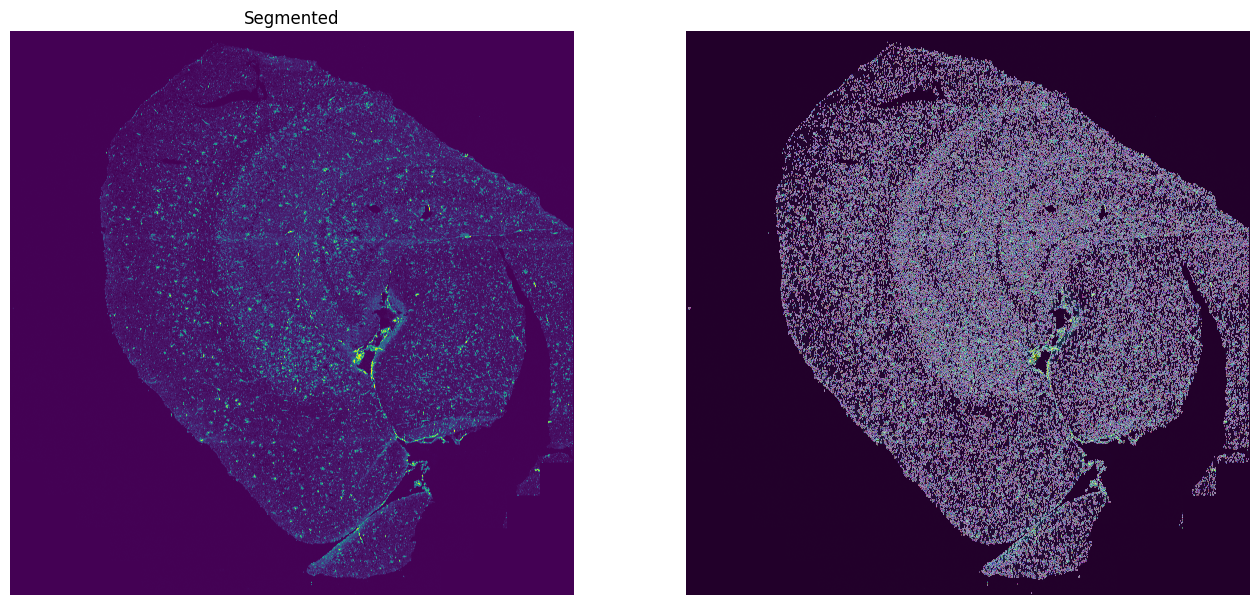

In [52]:
fig, ax = plt.subplots(1,2,figsize = (16, 8))

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('IF')

ax[1].imshow(img)
ax[1].imshow(labels, cmap=cmap, alpha=0.5)
ax[1].axis('off')
ax[0].set_title('Segmented')

plt.show()

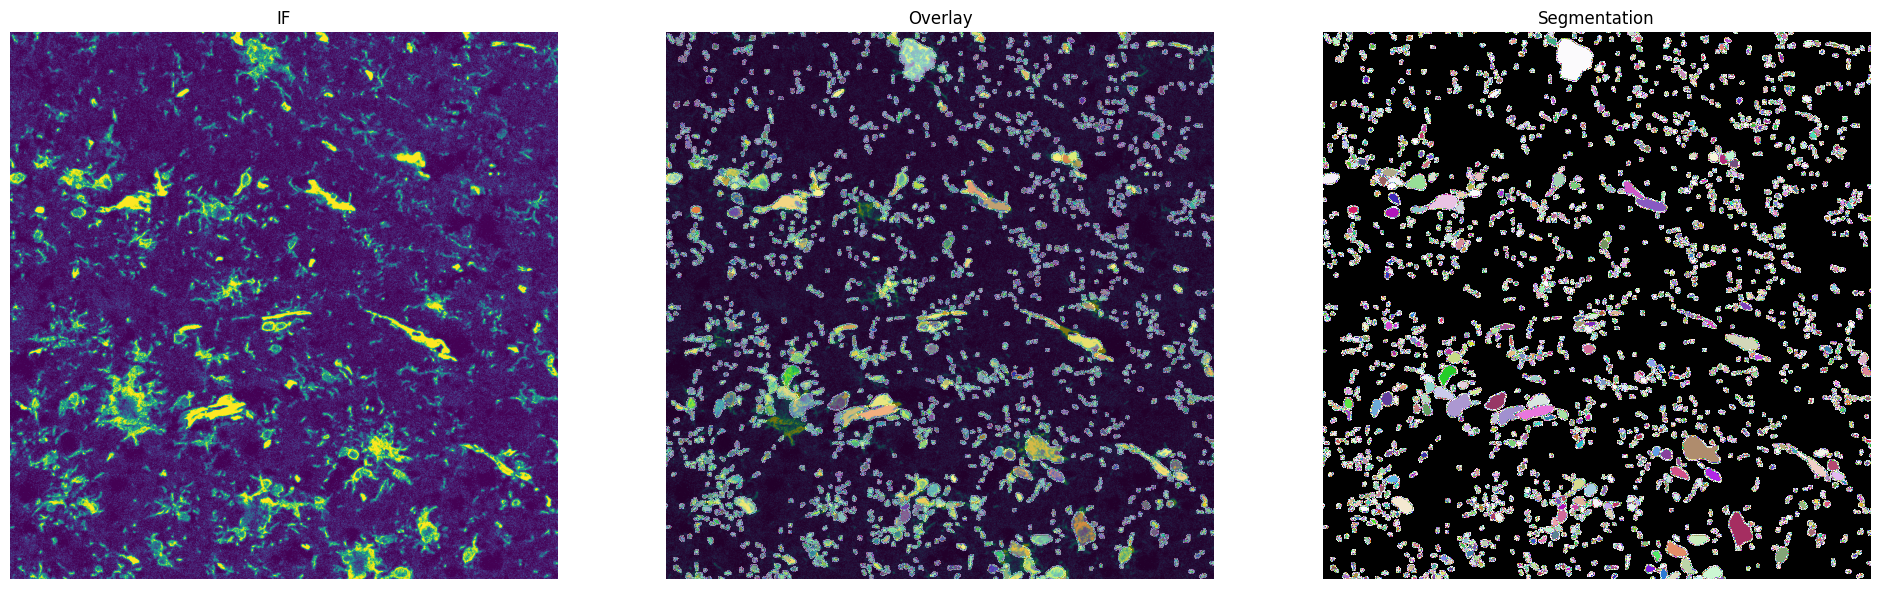

In [56]:
crop_x=8000
crop_y=8000
tile_size=1024
cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]
cropped_lbls = labels[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

_, ax = plt.subplots(1,3,figsize = (24, 8))

ax[0].imshow(cropped_img)
ax[0].axis('off')
ax[0].set_title('IF')

ax[1].imshow(cropped_img)
ax[1].imshow(cropped_lbls, cmap=cmap, alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Overlay')

ax[2].imshow(cropped_lbls, cmap=cmap)
ax[2].axis('off')
ax[2].set_title('Segmentation')

plt.show()